In [ ]:
from PIL import Image

def compress_image(input_path, output_path, quality=None, lossless=False):
    """
    Compress an image using either lossless (PNG) or lossy (JPEG) compression.

    Parameters:
        input_path (str): Path to the input image.
        output_path (str): Path to save the compressed image.
        quality (int, optional): Quality factor for JPEG (1-100). Higher means better quality but larger size.
        lossless (bool): If True, saves as PNG (lossless). If False, saves as JPEG (lossy).
    """
    with Image.open(input_path) as img:
        if lossless:
            img.save(output_path, format="PNG", optimize=True)
            print(f"Lossless (PNG) compression done: {output_path}")
        else:
            img.save(output_path, format="JPEG", quality=quality, optimize=True)
            print(f"Lossy (JPEG) compression done: {output_path} with quality={quality}")

# Example Usage
input_image = "tesla.jpg"  # Change to your image file
jpeg_output = "compressed_lossy.jpg"
png_output = "compressed_lossless.png"

# Lossy Compression (JPEG) with 50% quality
compress_image(input_image, jpeg_output, quality=50, lossless=False)

# Lossless Compression (PNG)
compress_image(input_image, png_output, lossless=True)


Lossy (JPEG) compression done: compressed_lossy.jpg with quality=50
Lossless (PNG) compression done: compressed_lossless.png


Original Image Size: 2206.27 KB
Compressed Image Size: 878.79 KB
Compression Ratio: 2.51


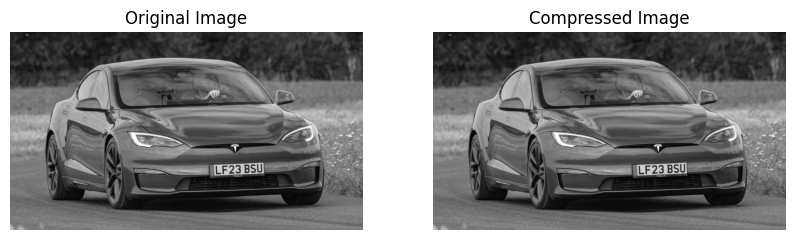

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def blockwise_dct(image, block_size=8):
    """Applies DCT block-wise to an image."""
    h, w = image.shape
    dct_image = np.zeros_like(image, dtype=np.float32)


    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i + block_size, j:j + block_size]
            # Apply DCT to the block
            dct_block = cv2.dct(np.float32(block))
            dct_image[i:i + block_size, j:j + block_size] = dct_block

    return dct_image

def blockwise_idct(dct_image, block_size=8):
    """Applies Inverse DCT block-wise to an image."""
    h, w = dct_image.shape
    image_reconstructed = np.zeros_like(dct_image, dtype=np.float32)


    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            dct_block = dct_image[i:i + block_size, j:j + block_size]
            # Apply Inverse DCT to the block
            block = cv2.idct(dct_block)
            image_reconstructed[i:i + block_size, j:j + block_size] = block

    return image_reconstructed


def blockwise_quantize_dct(dct_image, quant_matrix, block_size=8):
    """Quantizes the DCT coefficients block-wise."""
    h, w = dct_image.shape
    quantized_dct = np.zeros_like(dct_image, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i + block_size, j:j + block_size]
            quantized_block = np.round(block / quant_matrix)  # Quantization
            quantized_dct[i:i + block_size, j:j + block_size] = quantized_block

    return quantized_dct

def blockwise_dequantize_dct(quantized_dct, quant_matrix, block_size=8):
    """Dequantizes the DCT coefficients block-wise."""
    h, w = quantized_dct.shape
    dequantized_dct = np.zeros_like(quantized_dct, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = quantized_dct[i:i + block_size, j:j + block_size]
            dequantized_block = block * quant_matrix  # Dequantization
            dequantized_dct[i:i + block_size, j:j + block_size] = dequantized_block

    return dequantized_dct



import cv2
import numpy as np
import matplotlib.pyplot as plt


image_path = "/content/tesla.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


h, w = image.shape
new_h = (h + 7) // 8 * 8
new_w = (w + 7) // 8 * 8
padded_image = cv2.copyMakeBorder(image, 0, new_h - h, 0, new_w - w, cv2.BORDER_CONSTANT, value=0)


quant_matrix = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])


dct_image = blockwise_dct(padded_image)


quantized_dct = blockwise_quantize_dct(dct_image, quant_matrix)


dequantized_dct = blockwise_dequantize_dct(quantized_dct, quant_matrix)


image_reconstructed = blockwise_idct(dequantized_dct)


image_reconstructed = image_reconstructed[:h, :w]

# Clip the values to be in the 8-bit range and convert to uint8
image_reconstructed = np.clip(image_reconstructed, 0, 255).astype(np.uint8)

# Display the original and the compressed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_reconstructed, cmap='gray')
plt.title('Compressed Image')
plt.axis('off')

import os


original_image_path = "original_image.jpg"
cv2.imwrite(original_image_path, image)

compressed_image_path = "compressed_image.jpg"
cv2.imwrite(compressed_image_path, image_reconstructed)


original_size = os.path.getsize(original_image_path)
compressed_size = os.path.getsize(compressed_image_path)


print(f"Original Image Size: {original_size / 1024:.2f} KB")
print(f"Compressed Image Size: {compressed_size / 1024:.2f} KB")
print(f"Compression Ratio: {original_size / compressed_size:.2f}")


plt.show()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.8491 - loss: 0.4720 - val_accuracy: 0.9809 - val_loss: 0.0620
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 47s 32ms/step - accuracy: 0.9711 - loss: 0.0961 - val_accuracy: 0.9857 - val_loss: 0.0463
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 83s 32ms/step - accuracy: 0.9803 - loss: 0.0662 - val_accuracy: 0.9883 - val_loss: 0.0373
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - accuracy: 0.9851 - loss: 0.0500 - val_accuracy: 0.9882 - val_loss: 0.0393
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 83s 32ms/step - accuracy: 0.9873 - loss: 0.0424 - val_accuracy: 0.9892 - val_loss: 0.0400
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - accuracy: 0.9885 - loss: 0.0366 - val_accuracy: 0.9909 - val_loss: 0.0337
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.9899 - loss: 0.0288 - val_accuracy: 0.9910 - val_loss: 0.0367
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 79s 31ms/step - accuracy: 0.9915 -

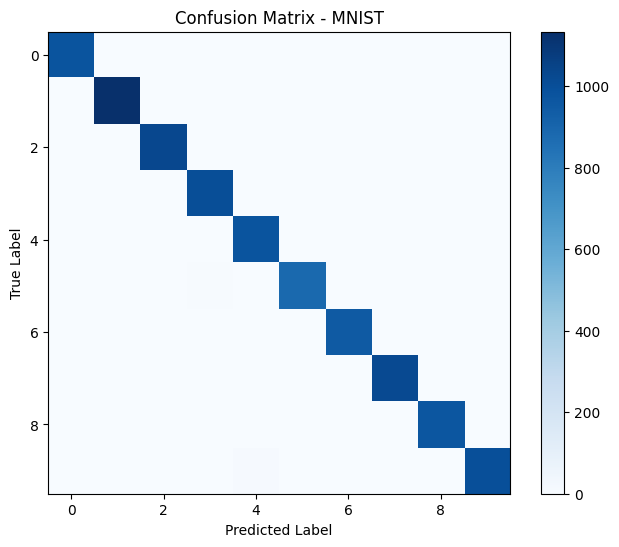

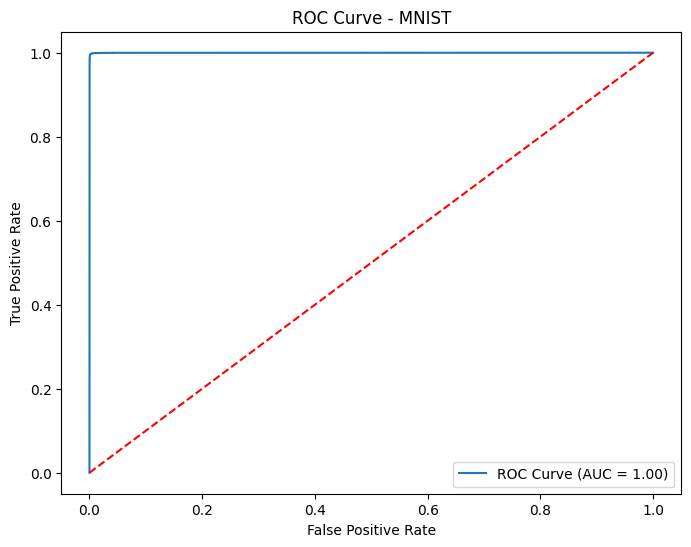

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Normalize pixel values (0-255 → 0-1)
x_train, x_test = x_train / 255.0, x_test / 255.0

#Reshape for CNN(28x28 grayscale → (28, 28, 1))
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

#One-hot.encode
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=32)


# Predict class probabilities
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.colorbar()
plt.title("Confusion Matrix - MNIST")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC & AUC
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MNIST")
plt.legend()
plt.show()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 97ms/step - accuracy: 0.2743 - loss: 1.9394 - val_accuracy: 0.4941 - val_loss: 1.3666
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 103ms/step - accuracy: 0.5065 - loss: 1.3559 - val_accuracy: 0.5768 - val_loss: 1.1893
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 94ms/step - accuracy: 0.5881 - loss: 1.1731 - val_accuracy: 0.6280 - val_loss: 1.0502
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 96ms/step - accuracy: 0.6341 - loss: 1.0375 - val_accuracy: 0.6408 - val_loss: 1.0346
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 98ms/step - accuracy: 0.6717 - loss: 0.9367 - val_accuracy: 0.6732 - val_loss: 0.9298
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 101ms/step - accuracy: 0.7013 - loss: 0.8598 - val_accuracy: 0.6924 - val_loss: 0.8692
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 95ms/step - accuracy: 0.7198 - loss: 0.8062 - val_accuracy: 0.7099 - val_loss: 0.8356
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 97ms/step - accuracy: 0.7400 - loss: 0.7446 

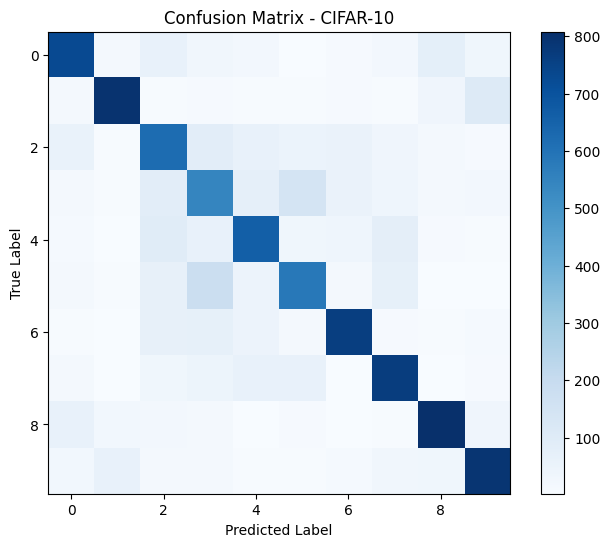

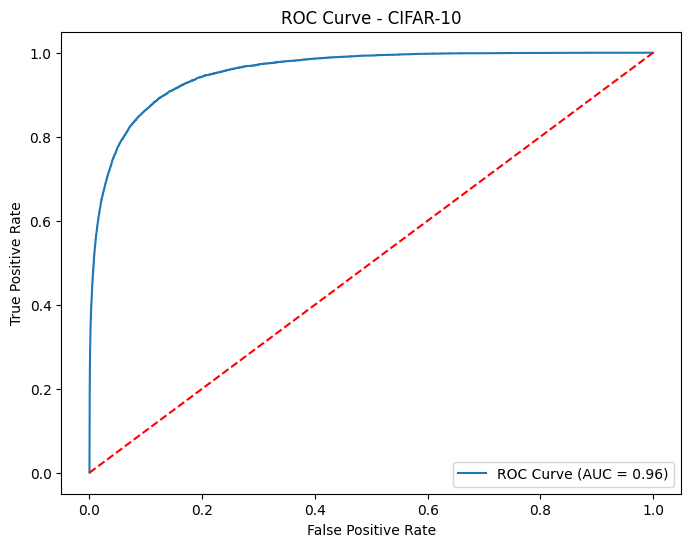

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values (0-255 → 0-1)
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot encode labels (10 classes)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=64)

# Predict class probabilities
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.colorbar()
plt.title("Confusion Matrix - CIFAR-10")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC & AUC
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CIFAR-10")
plt.legend()
plt.show()
